### Basic Ergonomic Colors
Here is a small set of colors in groups of consistent brightnesses and chromas:

In [15]:
SIMPLE_COLORS = [
    [["#000000"]],
    [["#4a4a4a"],
     ["#5f3d60",
      "#4a4d20",
      "#22544c"],
     ["#8f0000",
      "#0038db"]], 
    [["#868786"],
     ["#a77a60",
      "#9a7c96",
      "#768aa3",
      "#758f6d"],
     ["#d45c00",
      "#cf42cd",
      "#1b8cfe",
      "#28a113"]], 
    [["#dbdbdb"],
     ["#fbccda",
      "#f4d5a8",
      "#bfe7c1",
      "#c0e3ec",
      "#ddd6fd"],
     ["#ffd62b",
      "#b6f14d",
      "#4aff99"]], 
    [["#f4f5f4"],
     ["#d7ffed",
      "#fff4c9"],
     ["#fafd51"]],
    [["#ffffff"]]
]

In [16]:
HTML(demo(SIMPLE_COLORS))

By picking colors across brightness groups, you get a consistent contrast ratio. Any color pair not using the middle group will at least hover around WCAG AAA for any size text. Readability counts!

By picking colors of different chromas in the same brightness group, you can easily create the [attention hierarchy](https://colorusage.arc.nasa.gov/Percept_layers_1.php) for your application without interfering with the contrast ratio.

By picking colors of different hue in the same brightness+chroma group, you can add boundary hints (such as syntax highlighting or zebra striping) without interfering with the attention hierarchy or contrast ratio.

This was tricky! Equal spacing in RGB or HSL does the wrong thing. The brightness and chroma perceptual correlates are totally unaligned with the RGB colorspace, and not consistently correlated with HSL or any other computer-and-mathematics-friendly colorspace:

In [4]:
HTML(LIME_ON_BLUE)

The green in our RGB monitors is much brighter (perceptually, if not physically) than the red or blue. This is why the above table is missing dark saturated green or bright saturated red or blue. Those colors just aren't possible on our displays under normal calibration.

The shape of the RGB color gamut in a perceptually uniform space (I chose CIECAM02) is complicated. But mathematically, our problem is straightforward. We want contours of equal brightness and equal chroma. Brute force could feasibly compute these on every RGB color, and we would just filter from there. 

But fast feedback makes fast iteration, so some basic optimizations speed things up. The function mapping from RGB into our perceptual model is monotonic, so binary search works great. And because it is also continuous, the neighbors of a point provide strict bounds on its possible values.

If we wanted to optimize further, we could avoid computing whole planes, but we do want some nice visualizations later.

In [5]:
from colormath.color_objects import sRGBColor, XYZColor
from colormath.color_conversions import convert_color
from colormath.color_appearance_models import CIECAM02
import numpy
import math

WHITE_XYZ = convert_color(sRGBColor(1,1,1), XYZColor)
GREENS = 256
REDS_AND_BLUES = 256
class Office:
    def __init__(self, ambient_lightness, background):
        self.ambient_lightness = ambient_lightness
        self.background = background
        background_xyz = convert_color(background, XYZColor)
        self.background_brightness = background_xyz.xyz_y
        self._mesh_cache = {}
        
    def rgb_to_cbh(self, r, g, b):
        xyz = convert_color(sRGBColor(r, g, b), XYZColor)
        cbh = CIECAM02(
            xyz.xyz_x, xyz.xyz_y, xyz.xyz_z,
            WHITE_XYZ.xyz_x, WHITE_XYZ.xyz_y, WHITE_XYZ.xyz_z,
            c=0.69, n_c=1, f=1,
            l_a=self.ambient_lightness, y_b=self.background_brightness)
        return cbh.colorfulness, cbh.brightness, cbh.hue_angle

    def find_green(self, target_brightness, red, blue, lower_bound=0, upper_bound=1):
        # average case with no help from lower/upper bounds is 8 calls to .rgb_to_cbh
        assert lower_bound <= upper_bound
        b0 = None
        while upper_bound - lower_bound > 1/ GREENS:
            green = (upper_bound + lower_bound) / 2
            c, b, h = self.rgb_to_cbh(red, green, blue)
            if b < target_brightness:
                c0, b0, h0 = c, b, h
                lower_bound = green
            elif b > target_brightness:
                upper_bound = green
            else:
                return (green, green, c, b, h)
        if b0 is None:
            c0, b0, h0 = self.rgb_to_cbh(red, lower_bound, blue)
        return (lower_bound, upper_bound, c0, b0, h0)

    def _get_equal_brightness_mesh(self, target_brightness):
        '''The green values of neighbors give good higher and lower bounds.
        First we evaluate the corners of the mesh. Then for every interval, we 
        use the bounds from the endpoints to help compute the midpoint. This
        bisects the interval, giving us better bounds for the two new midpoints.
        This is saves ~80% of calls to .rgb_to_cbh
        '''
        mesh = numpy.zeros((REDS_AND_BLUES + 1, REDS_AND_BLUES + 1, 5))
        mesh[0, 0] = self.find_green(target_brightness, 0, 0)
        mesh[0, REDS_AND_BLUES] = self.find_green(target_brightness, 0, 1)
        mesh[REDS_AND_BLUES, 0] = self.find_green(target_brightness, 1, 0)
        mesh[REDS_AND_BLUES, REDS_AND_BLUES] = self.find_green(target_brightness, 1, 1)

        red_interval_size = REDS_AND_BLUES
        blue_interval_size = REDS_AND_BLUES
        while red_interval_size > 1:
            for red_idx in range(red_interval_size // 2, REDS_AND_BLUES, red_interval_size):
                red = red_idx / REDS_AND_BLUES
                for blue_idx in range(0, REDS_AND_BLUES + 1, blue_interval_size):
                    lower_bound, _, _, _, _ = mesh[red_idx + red_interval_size // 2, blue_idx]
                    _, upper_bound, _, _, _ = mesh[red_idx - red_interval_size // 2, blue_idx]

                    blue = blue_idx / REDS_AND_BLUES
                    mesh[red_idx, blue_idx] = self.find_green(target_brightness, red, blue, 
                                                         lower_bound=lower_bound, upper_bound=upper_bound)
            red_interval_size //= 2

        while blue_interval_size > 1:
            for blue_idx in range(blue_interval_size // 2, REDS_AND_BLUES, blue_interval_size):
                blue = blue_idx / REDS_AND_BLUES
                for red_idx in range(0, REDS_AND_BLUES + 1, red_interval_size):
                    lower_bound, _, _, _, _ = mesh[red_idx, blue_idx + blue_interval_size // 2]
                    _, upper_bound, _, _, _ = mesh[red_idx, blue_idx - blue_interval_size // 2]

                    red = red_idx / REDS_AND_BLUES
                    mesh[red_idx, blue_idx] = self.find_green(target_brightness, red, blue, 
                                                         lower_bound=lower_bound, upper_bound=upper_bound)
            blue_interval_size //= 2
        return mesh

    def get_equal_brightness_mesh(self, target_brightness):
        if target_brightness not in self._mesh_cache:
            self._mesh_cache[target_brightness] = self._get_equal_brightness_mesh(target_brightness)
        return self._mesh_cache[target_brightness]


BRIGHT_OFFICE = Office(100, sRGBColor(1,1,1))

In [13]:
from matplotlib import pyplot
%matplotlib widget

def display_brightness_level(mesh, pyplotaxes, target_brightness, target_chromas):
    for chroma in target_chromas:
        pyplotaxes.plot(
            chroma * numpy.cos(numpy.arange(0, 6.28, 0.01)), 
            chroma * numpy.sin(numpy.arange(0, 6.28, 0.01)),
            color='black'
        )
    
    theta = mesh[:, :, 4] * math.pi / 180
    x = mesh[:, :, 2] * numpy.cos(theta)
    y = mesh[:, :, 2] * numpy.sin(theta)
    
    step = 1/REDS_AND_BLUES
    blue = numpy.array([numpy.arange(0, 1 + step, step)] * (REDS_AND_BLUES + 1))
    red = blue.T
    green = (mesh[:, :, 0] + mesh[:, :, 1]) / 2
    rgb = numpy.zeros((REDS_AND_BLUES + 1, REDS_AND_BLUES + 1, 3))
    rgb[:, :, 0] = red
    rgb[:, :, 1] = green
    rgb[:, :, 2] = blue
    hexes = numpy.apply_along_axis(lambda rgb: sRGBColor(rgb[0], rgb[1], rgb[2]).get_rgb_hex(), 2, rgb)
    brightness_mask = numpy.abs(mesh[:,:,3] - target_brightness) < 0.5678 #arbitrary small number
    xs = x[brightness_mask]
    ys = y[brightness_mask]
    colors = hexes[brightness_mask]
    matching_colors = {}
    for chroma in target_chromas:
        chroma_mask = brightness_mask & (numpy.abs(mesh[:,:,2] - chroma) < 2.3456) #arbitrary small number
        hues = mesh[:,:,4][chroma_mask]
        matches = hexes[chroma_mask]
        matching_colors[chroma] = dict(zip(hues, matches))
    min_chroma = numpy.min(mesh[:, :, 2])
    matching_colors[0] = hexes[mesh[:, :, 2] == min_chroma][0]
    pyplotaxes.scatter(xs,ys,c=colors, marker='.')
    return matching_colors

def display_all(office, brightnesses=[68, 106, 155, 169], target_chromas=[20, 65]):
    matches = {}
    fig = pyplot.figure(figsize=(12,12))
    for i, brightness in enumerate(brightnesses):
        mesh = office.get_equal_brightness_mesh(brightness)
        axes = fig.add_subplot((len(brightnesses)+1//2), 2, i+1)
        axes.set_aspect('equal')
        matches[brightness] = display_brightness_level(mesh, axes, brightness, target_chromas)
    
    return matches, fig
    

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

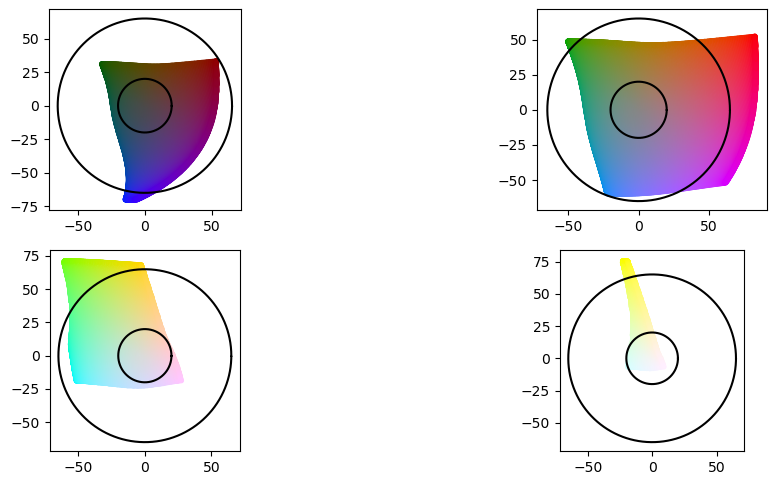

In [14]:
matches, fig = display_all(BRIGHT_OFFICE)
fig

In [9]:
import bisect

class ArcDict:
    """We want to look at hue-arcs of possibilities, rather than individual colors"""
    def __init__(self, vals, resolution):
        self._res = resolution
        self._vals = vals
        self._list = sorted(vals.keys())
    
    def __getitem__(self, needle):
        insertion_point = bisect.bisect(self._list, needle)
        
        if not self._list:
            raise KeyError(needle)
        elif insertion_point == 0:
            candidates = [self._list[0]]
        elif insertion_point == len(self._list):
            candidates = [self._list[-1]]
        else:
            candidates = [self._list[insertion_point - 1], self._list[insertion_point]]

        best_key = min(candidates, key=lambda key: abs(needle - key))
        if abs(needle - best_key) > self._res:
            raise KeyError(needle)
        else:
            return self._vals[best_key]
    
    def __repr__(self):
        intervals = [[self._list[0], self._list[0]]]
        for key in self._list:
            if key > intervals[-1][1] + self._res * 2:
                intervals.append([key, key])
            else:
                intervals[-1][1] = key
        key_to_str = lambda k: f'{round(k, 1)}: {self._vals[k]}'
        
        strs = [f'[{key_to_str(low)}]' if low == high else f'[{key_to_str(low)}, {key_to_str(high)}]' for [low, high] in intervals]
        range_text = ', '.join(strs)
        return f'ArcDict({range_text})'

In [10]:
for brightness, chromas in matches.items():
    for chroma, hues in chromas.items():
        if chroma == 0:
            print(brightness, chroma, hues)
        else:
            arc = ArcDict(hues, 5)
            print(brightness, chroma, arc)

68 20 ArcDict([-180.0: #25544a, 179.9: #13564a])
68 65 ArcDict([-101.5: #0038db, -81.3: #5700df], [32.2: #8f0000])
68 0 #4a4a4a
106 20 ArcDict([-179.9: #659186, 180.0: #679186])
106 65 ArcDict([-111.1: #018dfd, -108.2: #298bff], [-64.8: #a361ff, 49.9: #d45c00], [129.3: #4c9d00, 139.0: #00a228])
106 0 #868786
155 20 ArcDict([-180.0: #b3e9db, 179.9: #b9e7db])
155 65 ArcDict([90.9: #ffd62b, 151.2: #4aff99])
155 0 #dbdbdb
169 20 ArcDict([-179.5: #d5fff4, -158.5: #d7feff], [89.7: #fff4c9, 157.7: #d9ffe7], [167.8: #d7ffed, 178.8: #d5fff3])
169 65 ArcDict([103.0: #fffb54, 107.7: #f3ff52])
169 0 #f4f5f4


In [2]:
from IPython.display import HTML

def color_to_td_pair(color):
    td = '''<td style='color: {fg}; background-color: {bg}; text-rendering: optimizeLegibility; line-height:0; margin:0; font-weight: bold; font-size: x-large; font-family: monospace;'>{text}</td>'''
    return td.format(fg=color, bg='#f4f5f4', text=color) + td.format(fg="#000000", bg=color, text=color)
    
def brightness_group_to_rows(brightness):
    ret = ''
    
    nRows = max([len(chroma) for chroma in brightness])
    for i in range(nRows):
        pairs = [color_to_td_pair(chroma[i]) if i < len(chroma) else "<td style='background-color: #ffffff'/>"*2 for chroma in brightness]
        tds = ''.join(pairs)
        ret += f'''<tr>{tds}</tr>'''
    return ret

def demo(brightnesses):
    rows = list(map(brightness_group_to_rows, brightnesses))
    rows = ''.join(rows)
    return f'''<table>{rows}</table>'''

LIME_ON_BLUE = f'''<text style='font-weight: bold; color: HSL(120, 100%, 50%); background-color: HSL(240, 100%, 50%);'>
Lime (#00FF00, HSL(120, 100%, 50%)) on Blue (#0000FF, HSL(240, 100%, 50%))<br>
is quite readable, even though the HSL lightness is the same.</text>'''

In [ ]:
'''Future work:
Dim office

CIECAM is for dyes. Switch to a model for luminous stimuli:
https://www.osapublishing.org/josaa/fulltext.cfm?uri=josaa-35-12-2000&id=401230

incorporate H-K effect: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2659800/
'''